In [1]:
import re

from bs4 import BeautifulSoup, Comment
import os
import matplotlib.pyplot as plt

Script vyhlada dokumenty v danom adresary a vypise typy dokumentov.

In [ ]:
my_folder = "../data/pdfs/ROCNE SPRAVY 2020" # your path here
count = 0

pdf_count=0
xls_count=0
doc_count=0
others=0

for root, dirs, files in os.walk(my_folder):
    # if os.path.basename(root) == "CERI":
        # print((root, dirs, files))
    for f in files:
        if f.lower().endswith(".pdf") :
            pdf_count+=1
        elif f.lower().endswith(".xls") or f.lower().endswith(".xlsx"):
            xls_count+=1
            print(f)
        elif f.lower().endswith(".doc") or f.lower().endswith(".docx"):
            doc_count+=1
            print(f)
        else:
            others+=1


print((pdf_count, xls_count, doc_count, others))

    #count += len([fn for fn in files if fn.endswith(".pdf")])
#print(count)

In [2]:
from collections import defaultdict

my_folder = "../data/pdfs/ROCNE SPRAVY  2021" # your path here
count = 0

files_by_types = {}
files_by_types = defaultdict(lambda:0, files_by_types)

keywords_dict = {
    'pdf2htmlEX': ['pdf2htmlEX'],
    'LibreOffice': ['LibreOffice', 'Libre Office'],
    'OpenOffice': ['OpenOffice', 'Open Office'],
    'MS Word': ['MS Word', 'MSWord', 'Microsoft Word'],
    'Iris Business service':['Iris Business service'],
    'Sturnis 365': ['Sturnis 365'],
    'Aspose.Words':['Aspose.Words'],
    'PowerTools': ['PowerTools'],
    'Certent CDM HD': ['Certent CDM HD'],
    'XMLmind': ['XMLmind'],
    'Seahorse': ['Seahorse'],
    'INTEGIX by Ez-XBRL': ['INTEGIX by Ez-XBRL']
}

pairing = {}
file_stats = {}

for root, dirs, files in os.walk(my_folder):

    others = 0
    if root == my_folder:
        for d in dirs:
            full_file_path = os.path.join(root, d)
            pairing[full_file_path] = {}
            pairing[full_file_path]['convertor'] = set()
            pairing[full_file_path]['stats'] = {}

        for f in files:
            full_file_path = os.path.join(root, f)
            pairing[full_file_path] = {}
            pairing[full_file_path]['convertor'] = set()
            pairing[full_file_path]['stats'] = {}

    for f in files:
        full_file_path = os.path.join(root, f)
        file_key = full_file_path

        for k in pairing.keys():
            if k in full_file_path:
                file_key = k
                break

        if f.lower().endswith(".pdf") :
            files_by_types['pdf_count']+=1
            print(f)
        elif f.lower().endswith(".xls") or f.lower().endswith(".xlsx"):
            files_by_types['xls_count']+=1
            print(f)
        elif f.lower().endswith(".doc") or f.lower().endswith(".docx"):
            files_by_types['doc_count']+=1
            print(f)
        elif f.lower().endswith(".xhtml") or f.lower().endswith(".html"):
            files_by_types['xhtml_count']+=1

            html = open(full_file_path).read()
            soup = BeautifulSoup(html)
            comments = soup.find_all(string=lambda text: isinstance(text, Comment))

            for comment in comments:
                for key in keywords_dict:
                    for word in keywords_dict[key]:
                        if word.lower() in comment.lower():
                            pairing[file_key]['convertor'].add(key)

            for meta in soup.find_all('meta'):
                for key in keywords_dict:
                    for word in keywords_dict[key]:
                        for _attr in meta.attrs:
                            if word.lower() in meta.get(_attr).lower():
                                pairing[file_key]['convertor'].add(key)

            classes = set()
            tag_cnt_dict = {
                'img': 0,
                'div': 0,
                'table': 0,
                'p': 0,
                'tr': 0,
                'span': 0,
                'word_cnt': 0
            }
            avg_img_size = [0, 0]
            matches = re.findall(r'\b[A-Za-z]+\b', soup.getText())
            tag_cnt_dict['word_cnt'] = len(matches)
            if tag_cnt_dict['word_cnt'] < 1000:
                print(tag_cnt_dict['word_cnt'])
                print(full_file_path)
            tags = {tag.name for tag in soup.find_all()}
            for tag in tags:
                # find all element of tag

                for i in soup.find_all( tag ):
                    if tag in tag_cnt_dict.keys():
                        tag_cnt_dict[tag]+=1
                    if tag == 'img':
                        # print(avg_img_size)
                        avg_img_size[0]+=int(i.get('width', 0))
                        avg_img_size[1]+=int(i.get('height', 0))
                    # if tag has attribute of class
                    if i.has_attr( "class" ):
                        if len( i['class'] ) != 0:
                            classes.add(" ".join(i['class']))
            if not pairing[file_key]['stats']:
                pairing[file_key]['stats'] = tag_cnt_dict
            else:
                for k in pairing[file_key]['stats']:
                    if k != 'avg_size':
                        pairing[file_key]['stats'][k] += tag_cnt_dict[k]
            if tag_cnt_dict['img'] > 0 and (pairing[file_key]['stats']['img'] - tag_cnt_dict['img']) > tag_cnt_dict['img']:
                pairing[file_key]['stats']['avg_size'] = [avg_img_size[0]/tag_cnt_dict['img'], avg_img_size[1]/tag_cnt_dict['img']]
            else:
                pairing[file_key]['stats']['avg_size'] = avg_img_size
            classes_no_num = set()
            for c in classes:
                classes_no_num.update(set(''.join([i for i in c if not i.isdigit()]).split(" ")))


            if {'x', 'y', 'ff', 'fs', 'pf'}.issubset(classes_no_num):
                pairing[file_key]['convertor'].add('pdf2htmlEX')

            if {'P', 'T', 'Tabuľka', "Standard", "Tabuľka_A", "Table_A", "Table"}.issubset(classes_no_num):
                pairing[file_key]['convertor'].add('LibreOffice')

        else:
            others+=1

        if len(pairing[file_key]['convertor']) == 0:
            pairing[file_key]['convertor'].add('other')

print(files_by_types)
print("+++++++++++++++++++++++++++++++++++++++++")
print(pairing)
print("+++++++++++++++++++++++++++++++++++++++++")

keywords_dict['other'] = set()
list_of_lens = []

for key in keywords_dict:
    print("-------------")
    print(f"KEYWORD: {key}")
    print("-------------")
    cnt=0
    for f in pairing:
        if key in pairing[f]['convertor']:
            if key == 'other' and len(pairing[f]['convertor'])>1:
                print(f"\t {f} but {pairing[f]['convertor']}")
            else:
                cnt+=1
                print(f"\t {f}")
    list_of_lens.append(cnt)
    print(f"*******LEN: {cnt}************")




Tatry mountain resorts sprava 2021.pdf
ValidationResults_202206100612.xlsx
1
../data/pdfs/ROCNE SPRAVY  2021/DOLKAM SUJA sprava 2021/Doplnenie.xhtml
1
../data/pdfs/ROCNE SPRAVY  2021/DOLKAM SUJA sprava 2021/Vyhlasenie.xhtml
1
../data/pdfs/ROCNE SPRAVY  2021/DOLKAM SUJA sprava 2021/Prehlasenie o nezavislosti auditora.xhtml
1
../data/pdfs/ROCNE SPRAVY  2021/DOLKAM SUJA sprava 2021/Zverejnenie v HN.xhtml
221
../data/pdfs/ROCNE SPRAVY  2021/VUB/Všeobecná úverová banka _ konsolidovaná výročná správa.html
221
../data/pdfs/ROCNE SPRAVY  2021/VUB/Všeobecná úverová banka _ Ročná finančná správa.html
Vyhlasenie.pdf
defaultdict(<function <lambda> at 0x7f4e84591290>, {'xhtml_count': 70, 'pdf_count': 2, 'xls_count': 1})
+++++++++++++++++++++++++++++++++++++++++
{'../data/pdfs/ROCNE SPRAVY  2021/Pro Partners Holding': {'convertor': {'other', 'pdf2htmlEX'}, 'stats': {'img': 268, 'div': 49576, 'table': 0, 'p': 0, 'tr': 0, 'span': 71902, 'word_cnt': 25524, 'avg_size': [0, 0]}}, '../data/pdfs/ROCNE SPRA

In [3]:
pairing_to_store = pairing

for file in pairing:
    pairing[file]['content'] = set()
    if pairing[file]['stats']:
        if pairing[file]['convertor'] in ['pdf2htmlEX', 'LibreOffice', 'OpenOffice'] and pairing[file]['stats']['word_cnt'] < 5000:
            if pairing[file]['stats']['img'] > 40 or pairing[file]['stats']['avg_size'][0] > 400 or pairing[file]['stats']['avg_size'][1] > 400:
                pairing[file]['content'].add('image')
        if (pairing[file]['stats']['img'] > 50 or pairing[file]['stats']['avg_size'][0] > 500 or pairing[file]['stats']['avg_size'][1] > 500) and pairing[file]['stats']['word_cnt']<5000:
            pairing[file]['content'].add('image')
        if pairing[file]['stats']['tr'] > 400 or pairing[file]['stats']['table'] > 15:
            pairing[file]['content'].add('table')
        if pairing[file]['stats']['div'] > 100 or pairing[file]['stats']['p'] > 1000 or pairing[file]['stats']['span'] > 1000:
            pairing[file]['content'].add('text')
    if len(pairing[file]['content']) == 0:
        pairing[file]['content'].add('other')

all_sets = []
info_by_file_content = {}
for file in pairing:
    if 'image' in pairing[file]['content']:
        print(f"file: {file}, content: {pairing[file]}")
    if frozenset(pairing[file]['content']) in info_by_file_content.keys():
        info_by_file_content[frozenset(pairing[file]['content'])]+=1
    else:
        info_by_file_content[frozenset(pairing[file]['content'])]=1
    # all_sets.append(frozenset(pairing[file]['content']))

print(info_by_file_content)



file: ../data/pdfs/ROCNE SPRAVY  2021/Auctor Finance sprava 2021.xhtml, content: {'convertor': {'MS Word'}, 'stats': {'img': 52, 'div': 1, 'table': 0, 'p': 352, 'tr': 0, 'span': 444, 'word_cnt': 1600, 'avg_size': [30940, 42258]}, 'content': {'image'}}
file: ../data/pdfs/ROCNE SPRAVY  2021/Mint Metropolis sprava 2021.xhtml, content: {'convertor': {'MS Word'}, 'stats': {'img': 11, 'div': 15, 'table': 16, 'p': 2514, 'tr': 466, 'span': 5557, 'word_cnt': 3107, 'avg_size': [5188, 5568]}, 'content': {'table', 'image', 'text'}}
file: ../data/pdfs/ROCNE SPRAVY  2021/Garfin Holding-chyba konsolidovana uctovna zavierka.xhtml, content: {'convertor': {'pdf2htmlEX'}, 'stats': {'img': 69, 'div': 2373, 'table': 0, 'p': 1, 'tr': 0, 'span': 7814, 'word_cnt': 4245, 'avg_size': [0, 0]}, 'content': {'image', 'text'}}
file: ../data/pdfs/ROCNE SPRAVY  2021/FRIGO sprava 2021.xhtml, content: {'convertor': {'pdf2htmlEX'}, 'stats': {'img': 66, 'div': 3902, 'table': 0, 'p': 1, 'tr': 0, 'span': 4268, 'word_cnt': 3

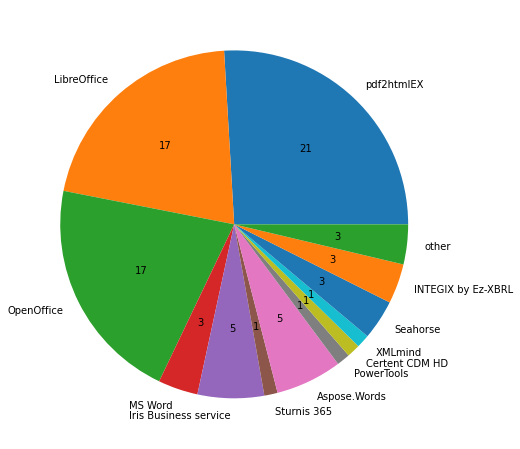

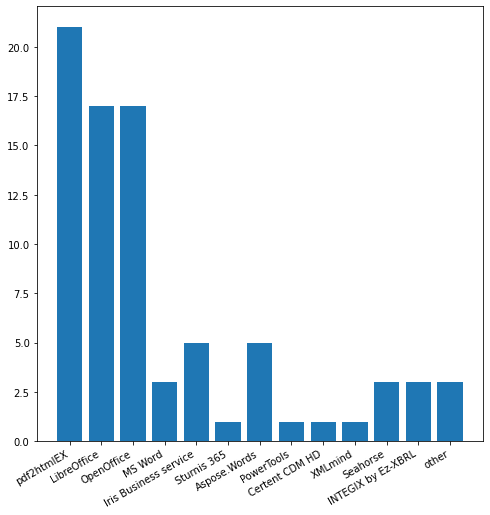

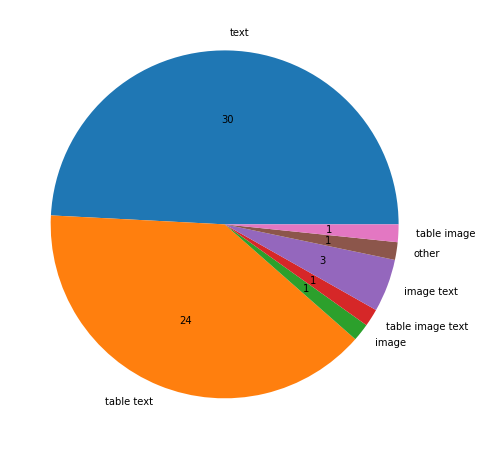

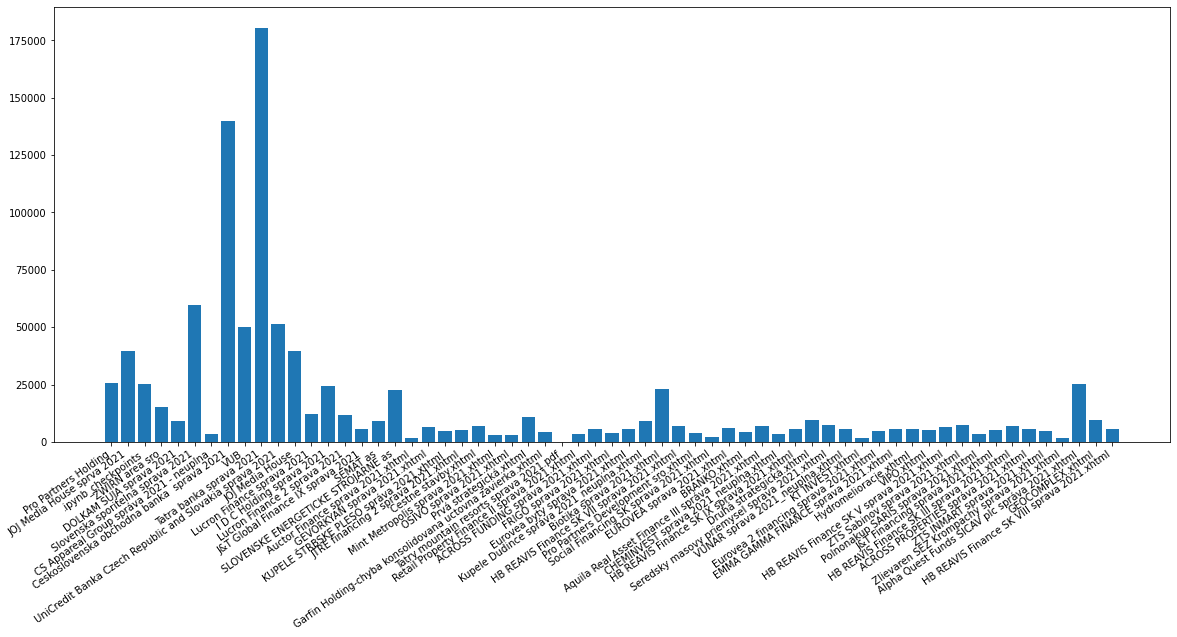

In [4]:
fig = plt.figure(figsize=(8, 8))
plt.pie(list_of_lens, labels=(keywords_dict.keys()), autopct=lambda x: '{:.0f}'.format(x * sum(list_of_lens) / 100))
plt.show()

fig = plt.figure(figsize=(8, 8))
ax= plt.subplot()
plt.bar(keywords_dict.keys(), list_of_lens)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

fig = plt.figure(figsize=(8, 8))
plt.pie(info_by_file_content.values(), labels=([' '.join(list(key)) for key in info_by_file_content.keys()]), autopct=lambda x: '{:.0f}'.format(x * sum(info_by_file_content.values()) / 100))
plt.show()

fig = plt.figure(figsize=(20, 8))
ax= plt.subplot()
plt.bar([k.split("/")[-1] for k in pairing.keys()],
    [pairing[file]['stats']['word_cnt'] if pairing[file]['stats'] else 0 for file in pairing])
plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
plt.show()